# Data Wrangling of Santander Cycles Open Data

For the analysis, I have used the Open Data for the Santander Cycles bike share scheme in London.
Here, I have done some data manipulation from the data that I acquired from Transport for London Open Data.

For this challenge, I did not use the real-time data from the API, but focused on the locations for bike points and some journeys data.

## Fetching the Bike Points

The data for bike points can be found from the [TfL Unified API](https://api.tfl.gov.uk/bikepoint).
I have converted this file into a GeoJSON file for analysis.

The data directory is not pushed to GitHub.
Downloads the raw data into `DL_path`, and saves the points assigned by `points_path`.

In [1]:
import os
import json
import urllib.request

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.merge
from rasterio.plot import show
import matplotlib.pyplot as plt

In [2]:
# Converts Bike Points into GeoJSON file

# set paths
DL_path = "data/cycles/DL_data"
points_path = "data/cycles/points"
points_fn = "BikePoints.geojson"
source_url = "https://api.tfl.gov.uk/BikePoint"

# skip the conversion if already done:
if os.path.exists(os.path.join(points_path, points_fn)):
    print("File already converted.")

# do the conversion only if not done already
else:
    print("Converting from JSON file.")
    # import json file from TfL Unified API if not already in local
    # if file already in local, load json from local
    if os.path.exists(os.path.join(DL_path, "BikePoint.json")):
        print("Loading file from local")
        docks = json.load(open(os.path.join(DL_path, "BikePoint.json")))
    
    # if file not in local, download from source_url
    else:
        print(f"Download from {source_url}") 
        with urllib.request.urlopen(source_url) as source:
            docks = json.load(source)
        # save to local
        docks_DL_data = json.dumps(docks)
        # creates saving directory if does not exist
        if not os.path.exists(DL_path):
            os.makedirs(DL_path)
        # save json file
        with open(os.path.join(DL_path, "BikePoint.json"), "w") as f:
            f.write(docks_DL_data)
    
    # create output file
    output = {
        "type": "FeatureCollection",
        "features" : []
    }
    
    # add docks data
    for d in docks:
        for x in d["additionalProperties"]:
            if x["key"] == "TerminalName":
                id = x["value"]
        lat = d["lat"]
        lon = d["lon"]
        long_name = d["commonName"]
    
        #Separate area and specific port name
        # comma = d["commonName"].rfind(",")
        # if comma != -1:
        #     loc = d["commonName"][:comma]
        #     area = d["commonName"][comma+1:]
        # else:
        #     loc = ""
        #     area = ""
            
        for x in d["additionalProperties"]:
            if x["key"] == "NbDocks":
                docks = x["value"]
    
        # GeoJSON features
        port = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [lon, lat]
            },
            "properties": {
                "id": id,
                "name": long_name,
                # "location": loc,
                # "area": area,
                "ports": docks,
            },
        }
        output["features"].append(port)
    
    # create output
    docks_geojson = json.dumps(output)
    
    # creates saving directory if does not exist
    if not os.path.exists(points_path):
        os.makedirs(points_path)
    
    # save json file
    with open(os.path.join(points_path, points_fn), "w") as f:
        f.write(docks_geojson)
    print("converting finished.")
        

File already converted.


## Create GeoDataFrame

In [3]:
# create geodataframe

points_gdf = gpd.read_file(os.path.join(points_path, points_fn))

# split location and zone
name = ['location', 'zone']
points_gdf[name] = points_gdf['name'].str.rsplit(pat = ',', n = 1, expand = True)

# clear spaces before and after commas
for n in name:
    points_gdf[n] = points_gdf[n].str.replace(r'^( +)|( +)$', r'', regex = True)

# fix zone name
replaces = {
    "Kings Cross": "King's Cross",
    "Parsons Green": "Parson's Green",
    "St Lukes": "St. Luke's",
    "St Pauls": "St. Paul's",
    "St.John's Wood": "St. John's Wood",
}
points_gdf['zone'] = points_gdf.zone.replace(replaces)

# convert into British National Grid
points_gdf = points_gdf.to_crs('EPSG:27700')

## Get raster data to extract location

Raster data for elevation created by the [Environmental Agency](https://www.data.gov.uk/dataset/e529ca2f-b4ce-403e-8cef-ab821061c4f3/lidar-composite-digital-terrain-model-dtm-2m)

In [4]:
# load data

# set the grids we are using for analysis
grid = ['TQ27', 'TQ28', 'TQ37', 'TQ38']
subgrid = ['ne', 'nw', 'se', 'sw']

# set path to convert from
elev_path = [f'zip+file://data/elevation/lidar_composite_dtm-2022-2-{g}{s}.zip!/{g}{s}_DTM_2m.tif' for g in grid for s in subgrid]

# set destination path
elev_dest_path = 'data/elevation/london_elevation.tif'

# check if already done
if os.path.exists(elev_dest_path):
    print("Files already merged")

# do the merge
else:
    # load raster data as list of rasterio files
    src = []
    for idx, path in enumerate(elev_path):
        src.append(rasterio.open(path))
    
    # merge the items in list into single raster
    merged, output = rasterio.merge.merge(src)
    
    # copy metadata from original raster
    out_meta = src[0].meta.copy()
    
    # edit where this needs update
    out_meta.update(
        {
            'driver': 'GTiff',
            'height': merged.shape[1],
            'width': merged.shape[2],
            'transform': output,
            'crs': 'EPSG:27700'        
        }
    )
    
    # write file to data
    with rasterio.open(elev_dest_path, 'w', **out_meta) as dest:
        dest.write(merged)

Files already merged


In [5]:
elevation = rasterio.open("data/elevation/london_elevation.tif")

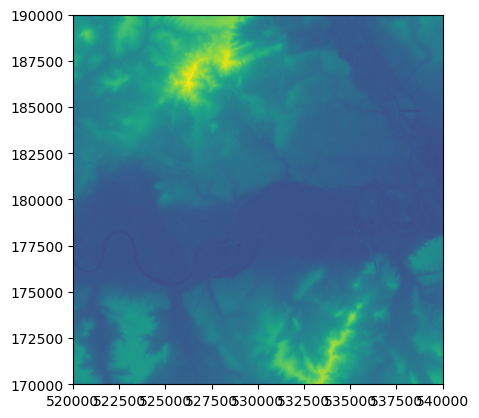

<Axes: >

In [6]:
show(elevation)

## Extracting height from raster data

For each of the points, extract the height from the provided data

In [7]:
# create list of coordinates for each of the docking stations
coords_list = [(x, y) for x, y in zip(points_gdf["geometry"].x, points_gdf["geometry"].y)]

# extract the height data for raster
# each value is returned as a list with a length of 1, so taking the first item
points_gdf['height'] = [x[0] for x in elevation.sample(coords_list)]

In [11]:
# save as geoparquet

points_parquet_fn = 'docking_stations.geoparquet'
points_gdf.to_parquet(os.path.join(points_path, points_parquet_fn))